# Hamiltonian Neural Networks

In this tutorial we train **Hamiltonian Neural Networks** (HNNs), a useful tool to learn simmetries and conservation laws from data, firstly introduced in [Greydanus S., et al., 2019](https://arxiv.org/abs/1906.01563).

Let $q\in\mathbb{R}^n$ be a vector of generalized positions and let $p\in\mathbb{R}^n$ be the corresponding generalized momenta. Roughly speaking, HNNs mimick the canonical equations of classical mechanics

$$
    \begin{aligned}
        &\dot q = \nabla_p\mathcal{H}(q,p)\\
        &\dot p = -\nabla_q\mathcal{H}(q,p)
    \end{aligned}
$$

where the Hamiltonian function $\mathcal{H}$ is parametrized by a neural network $\mathcal H_\theta(q, p)$. In the original paper, provided a dataset of tuples $(\dot q, \dot p)$ generated by some conservative dynamical process, the HNN is trained (the parameters of $\mathcal{H}$ optimized) to minimize a loss of type

$$
    \ell_\theta := || \dot q - \nabla_p\mathcal H_\theta||_2^2 + || \dot p + \nabla_q\mathcal H_\theta||_2^2 
$$

We hereby show how to implement this experiment in torchdyn for a simple mass-spring system

In [1]:
from torchdyn.core import NeuralODE
from torchdyn.models import HNN
from torchdyn.nn import DataControl, DepthCat, Augmenter
from torchdyn.datasets import *
from torchdyn.utils import *

The vector field of an HNN, to be passed to our `DEFunc` can be simply defined as follows

In [2]:
import torch
import torch.nn as nn

class HNN(nn.Module):
    def __init__(self, Hamiltonian:nn.Module, dim=1):
        super().__init__()
        self.H = Hamiltonian
        self.n = dim
    def forward(self, x):
        with torch.set_grad_enabled(True):
            x = x.requires_grad_(True)
            gradH = torch.autograd.grad(self.H(x).sum(), x, allow_unused=False, create_graph=True)[0] 
        return torch.cat([gradH[:,self.n:], -gradH[:,:self.n]], 1).to(x)

We consider a 1D mass-spring system

$$
    m\ddot x - kx = 0,~~x(0)=0,~~\dot x(0)=1
$$

and we let $q=x$, $p=\dot x$. We then train the neural network on data generated from a single trajectory of the system


## "Static" Training

In [3]:
import torch.utils.data as data
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

t = torch.linspace(0,1, 100).reshape(-1,1)
X = torch.cat([
    torch.sin(2*np.pi*t),
    torch.cos(2*np.pi*t)
],1).to(device)

y = torch.cat([
    torch.cos(2*np.pi*t),
    -torch.sin(2*np.pi*t)
],1).to(device)

train = data.TensorDataset(X, y)
trainloader = data.DataLoader(train, batch_size=len(X), shuffle=False)

In [4]:
import pytorch_lightning as pl

class Learner(pl.LightningModule):
    def __init__(self, model:nn.Module):
        super().__init__()
        self.model = model
        self.c = 0
    
    def forward(self, x):
        return self.model.defunc(0,x)
    
    def loss(self, y, y_hat):
        return ((y-y_hat)**2).sum()
    
    def training_step(self, batch, batch_idx):
        x, y = batch      
        y_hat = self.model.defunc(0,x)   
        loss = self.loss(y_hat, y)
        logs = {'train_loss': loss}
        return {'loss': loss, 'log': logs}   
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=0.01)

    def train_dataloader(self):
        return trainloader

In [5]:
HamFunc = HNN(nn.Sequential(
            nn.Linear(2,64),
            nn.Tanh(),
            nn.Linear(64,1))).to(device)

In [7]:
model = NeuralODE(HamFunc).to(device)

learn = Learner(model)
trainer = pl.Trainer(min_epochs=500, max_epochs=1000)
trainer.fit(learn)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type     | Params
-----------------------------------
0 | model | NeuralDE | 257   
/home/jyp/michael_dev/testenv/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:25: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


1

Text(0.5, 1.0, "HHN's trajectories & training data")

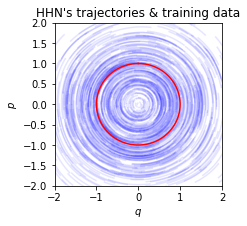

In [8]:
# Sample random initial conditions
X_t = torch.randn(1000, 2).to(device)
# Evaluate the HNN trajectories for 1s
s_span = torch.linspace(0, 1, 100)
traj = model.trajectory(X_t, s_span).detach().cpu()

# Plot the HHN's trajectories with random ICs
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
color = ['orange', 'blue']
for i in range(len(X_t)):
    ax.plot(traj[:,i,0], traj[:,i,1], color='blue', alpha=0.1);
ax.plot(X[:,0].cpu(),X[:,1].cpu(), color='red')
ax.set_xlim([-2,2])
ax.set_ylim([-2,2])
ax.set_xlabel(r"$q$")
ax.set_ylabel(r"$p$")
ax.set_title("HHN's trajectories & training data")

Text(0.5, 1.0, 'Learned Hamiltonian & Vector Field')

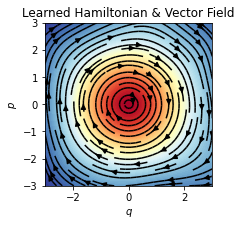

In [9]:
n_grid =  50
x = torch.linspace(-3,3,n_grid)
Q, P = torch.meshgrid(x,x)
H, U, V = torch.zeros(Q.shape), torch.zeros(Q.shape), torch.zeros(Q.shape)
for i in range(n_grid):
    for j in range(n_grid):
        x = torch.cat([Q[i,j].reshape(1,1),P[i,j].reshape(1,1)],1).to(device)
        H[i,j] = model.defunc.m.H(x).detach().cpu()
        O = model.defunc(0,x).detach().cpu()
        U[i,j], V[i,j] = O[0,0], O[0,1]
        
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
ax.contourf(Q,P,H,100,cmap='RdYlBu')
ax.streamplot(Q.T.numpy(),P.T.numpy(),U.T.numpy(),V.T.numpy(), color='black')
ax.set_xlim([Q.min(),Q.max()])
ax.set_ylim([P.min(),P.max()])
ax.set_xlabel(r"$q$")
ax.set_ylabel(r"$p$")
ax.set_title("Learned Hamiltonian & Vector Field")

## HNNs as General-Purpose Modules

If we want to try using using an HNN as a general-purpose DL module, e.g. for a classification task, you can do it well in `torchdyn`. Let us introduce a simple toy example

**Data**

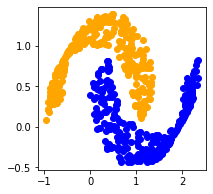

In [10]:
# Generate data with torchdyn utilities
d = ToyDataset()
X, yn = d.generate(n_samples=520, dataset_type='moons', noise=.4)    

colors = ['orange', 'blue'] 
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
for i in range(len(X)):
    ax.scatter(X[i,0], X[i,1], color=colors[yn[i].int()])

In [11]:
# Load data into dataloader
X_train = torch.Tensor(X).to(device)
y_train = torch.LongTensor(yn.long()).to(device)

train = data.TensorDataset(X_train, y_train)
trainloader = data.DataLoader(train, batch_size=len(X), shuffle=False)

**Learner**

In [12]:
# Define Learner - we will use MSE Loss
class Learner(pl.LightningModule):
    def __init__(self, model:nn.Module):
        super().__init__()
        self.model = model
    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch      
        y_hat = self.model(x)   
        loss = nn.CrossEntropyLoss()(y_hat, y)
        logs = {'train_loss': loss}
        return {'loss': loss, 'log': logs}   
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=0.005)

    def train_dataloader(self):
        return trainloader

In [13]:
# Define Hamiltonian and DEFunc
HamFunc = HNN(nn.Sequential(
            nn.Linear(2,64),
            nn.Tanh(),
            nn.Linear(64,64),
            nn.Tanh(),
            nn.Linear(64,1)    
)).to(device)

In [16]:
# Define Neural ODE with Hamiltonian vector field 
model = nn.Sequential(
    NeuralODE(HamFunc,
             solver='dopri5',
             sensitivity='adjoint'),
    nn.Linear(2,2)
).to(device)
# We append a linear out layer after NeuralDE

In [17]:
# Train the HNN with adjoint gradient just like any other model in torchdyn
learn = Learner(model)
trainer = pl.Trainer(min_epochs=200, max_epochs=250)
trainer.fit(learn)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 4 K   


1

**Plot Trajectories in the phase space**

In [18]:
s_span = torch.linspace(0, 1, 100)
traj = model[0].trajectory(X_train, s_span).detach().cpu()

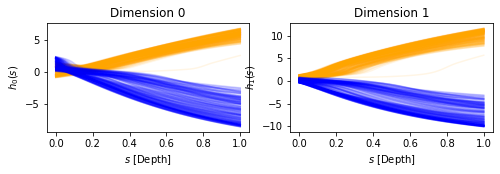

In [19]:
plot_2D_depth_trajectory(s_span, traj, yn, len(X))

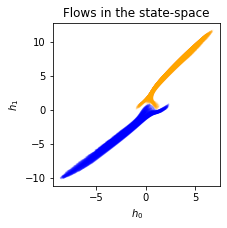

In [20]:
plot_2D_state_space(traj, yn, len(X))

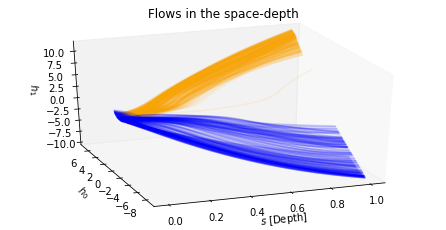

In [21]:
plot_2D_space_depth(s_span, traj, yn, len(X))

**Plot Learned Hamiltonian Function over vector field**

Text(0.5, 1.0, 'Learned Hamiltonian & Vector Field')

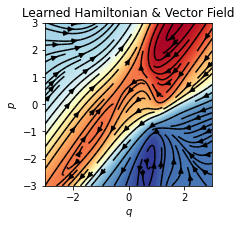

In [22]:
n_grid =  50
x = torch.linspace(-3,3,n_grid)
Q, P = torch.meshgrid(x,x)
H, U, V = torch.zeros(Q.shape), torch.zeros(Q.shape), torch.zeros(Q.shape)
for i in range(n_grid):
    for j in range(n_grid):
        x = torch.cat([Q[i,j].reshape(1,1),P[i,j].reshape(1,1)],1).to(device)
        H[i,j] = model[0].defunc.m.H(x).detach().cpu()
        O = model[0].defunc(0,x).detach().cpu()
        U[i,j], V[i,j] = O[0,0], O[0,1]
        
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
ax.contourf(Q,P,H,100,cmap='RdYlBu')
ax.streamplot(Q.T.numpy(),P.T.numpy(),U.T.numpy(),V.T.numpy(), color='black')
ax.set_xlim([Q.min(),Q.max()])
ax.set_ylim([P.min(),P.max()])
ax.set_xlabel(r"$q$")
ax.set_ylabel(r"$p$")
ax.set_title("Learned Hamiltonian & Vector Field")